# Setup

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/ANN_LEGO_Project/

/content/drive/MyDrive/ANN_LEGO_Project


In [ ]:
!pip install selenium
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,575 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Err:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
  The following signatures couldn't be verified because the public key is not available: NO_PUBKEY A4B469963BF863CC
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bion

In [ ]:
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
import os
import requests
import time
import shutil
from selenium import webdriver
from binascii import a2b_base64
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import pandas as pd
import numpy as np

import threading
from queue import Queue

thread_count = 50
threads = []

# Initial queue
queue = Queue(0)

from base64 import b64decode

# Code for Downloading from Google

In [ ]:
def download_google_images(search_terms):
    print("Downloading images from Google...")
    start_time = time.time()

    # Setup download folder
    downloads = "dataset"
    if not os.path.exists(downloads):
        shutil.mkdir(downloads)

    # Chrome Options
    options = webdriver.ChromeOptions()
    options.headless = True
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    options.add_argument('--ignore-certificate-errors')
    options.add_argument('--ignore-ssl-errors')

    # Create a browser instance
    browser = webdriver.Chrome("chromedriver", chrome_options=options)

    for search_term in search_terms:
        print("Searching for: ", search_term)
        search_url = 'https://www.google.com/search?q=' + search_term.replace(" ", "+") + '&tbm=isch'
        print("Search URL: ", search_url)
        browser.get(search_url)

        # Image urls
        img_urls = set()

        for _ in range(20):
            img_elements = browser.find_elements_by_xpath('//img[@class="rg_i Q4LuWd"]')
            if not img_elements:
                img_elements = browser.find_elements_by_xpath('//div[@class="bRMDJf islir"]/img')

            for img_element in img_elements:
                # on the element we get the src
                img_url = img_element.get_attribute('src')

                if img_url:
                    img_urls.add(img_url)

            # Wait up to 1 second
            time.sleep(np.random.uniform(0.2,1))

            browser.execute_script("window.scrollBy(0, 100000)")

        print('Number of image urls found:', len(img_urls))


        img_dir = os.path.join(downloads, search_term.lower().replace(" ", "_"))
        if not os.path.exists(img_dir):
            os.makedirs(img_dir)

        count = 0

        for img_url in img_urls:
          img_path = os.path.join(img_dir, '{0}.jpg'.format(count))
          count += 1

          with open(img_path, 'wb') as f:
            if 'data:image' in img_url:
                # Get only revelant data, deleting "data:image/png;base64,"
                data = img_url.split(',', 1)[1]
                f.write(b64decode(data))
            else:
                page = requests.get(img_url)
                f.write(page.content)

    # Quit the browser
    browser.quit()

    execution_time = (time.time() - start_time) / 60.0
    print("Download execution time (mins)", execution_time)

# Function to Download from bricklink

In [ ]:
def download_bricklink_images(search_category_ids):
    print("Downloading images from bricklink...")
    start_time = time.time()

    # Setup download folder
    downloads = "minifigures"
    if not os.path.exists(downloads):
        os.mkdir(downloads)

    # Chrome Options
    options = webdriver.ChromeOptions()
    options.headless = True
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    options.add_argument('--ignore-certificate-errors')
    options.add_argument('--ignore-ssl-errors')

    # Create a browser instance
    browser = webdriver.Chrome("chromedriver", chrome_options=options)

    count = 0

    for search_category_id in search_category_ids:
        print("Searching for images from category ID: ", search_category_id)

        # Image urls
        img_urls = set()

        page_number = 1
        while True:
            # if any of the found img_url is already in img_urls, break the loop of expanding img_urls and proceed to saving
            search_url = 'https://www.bricklink.com/catalogList.asp?pg=' + str(page_number) + '&catString=' + search_category_id + '&catType=M'
            # print("Search URL: ", search_url) 
            browser.get(search_url)

            candidate_img_urls = set([element.get_attribute('src') for element in browser.find_elements_by_xpath('//img[@class="l-block l-relative"]')])

            if not candidate_img_urls.isdisjoint(img_urls):
                break
            
            img_urls.update(candidate_img_urls)
            page_number += 1
        
        print('Number of image urls found:', len(img_urls))

        for img_url in img_urls:
            img_path = os.path.join(downloads, '{0}.jpg'.format(count))
            count += 1

            with open(img_path, 'wb') as f:
                if 'data:image' in img_url:
                    # Get only revelant data, deleting "data:image/png;base64,"
                    data = img_url.split(',', 1)[1]
                    f.write(b64decode(data))
                else:
                    page = requests.get(img_url)
                    f.write(page.content)

    print('Total images downloaded:', count)

    # Quit the browser
    browser.quit()

    execution_time = (time.time() - start_time) / 60.0
    print("Download execution time (mins)", execution_time)

In [ ]:
all_search_category_ids = ['747', '69', '1125', '124', '67', '804', '971', '920',
                           '789', '790', '746', '227', '390', '759', '61', '34', 
                           '573', '473', '65', '174', '768']


download_bricklink_images(all_search_category_ids)

Searching for images from category ID:  747
Number of image urls found: 26
Searching for images from category ID:  69
Number of image urls found: 29
Searching for images from category ID:  1125
Number of image urls found: 47
Searching for images from category ID:  124
Number of image urls found: 87
Searching for images from category ID:  67
Number of image urls found: 3082
Searching for images from category ID:  804
Number of image urls found: 83
Searching for images from category ID:  971
Number of image urls found: 86
Searching for images from category ID:  920
Number of image urls found: 93
Searching for images from category ID:  789
Number of image urls found: 110
Searching for images from category ID:  790
Number of image urls found: 54
Searching for images from category ID:  746
Number of image urls found: 684
Searching for images from category ID:  227
Number of image urls found: 368
Searching for images from category ID:  390
Number of image urls found: 279
Searching for images

# Preprocess Images

In [ ]:
from PIL import Image     
import matplotlib.pyplot as plt                                         
import os, sys    
                   

path = "minifigures/"
dirs = os.listdir(path)                                       

def add_margin_resize(newsize=(80, 80)):
    count = 0
    for img_file in dirs:
        img = Image.open(os.path.join(path, img_file))

        width, height = img.size

        if height > width:
            right = left = int((height-width)/2)
            top = bottom = 0 

        else:
            top = bottom = int((width-height)/2)
            left = right = 0

        new_width = width + right + left
        new_height = height + top + bottom

        img_square = Image.new(img.mode, (new_width, new_height), (255, 255, 255))
        img_square.paste(img, (left, top))

        img_square_resized = img_square.resize(newsize)

        img_square_resized.save(path + img_file.strip('.jpg') + '_preprocessed.jpg', quality=100)

        if count % 100 == 0:
            print('minifigures_preprocessed/' + img_file)
        
        count += 1

add_margin_resize()


minifigures/7583_preprocessed.jpg
minifigures/7584_preprocessed.jpg
minifigures/7585_preprocessed.jpg
minifigures/7586_preprocessed.jpg
minifigures/7587_preprocessed.jpg
minifigures/7588_preprocessed.jpg
minifigures/7589_preprocessed.jpg
minifigures/7590_preprocessed.jpg
minifigures/7591_preprocessed.jpg
minifigures/7592_preprocessed.jpg
minifigures/7593_preprocessed.jpg
minifigures/7594_preprocessed.jpg
minifigures/7595_preprocessed.jpg
minifigures/7596_preprocessed.jpg
minifigures/7597_preprocessed.jpg
minifigures/7598_preprocessed.jpg
minifigures/7599_preprocessed.jpg
minifigures/7600_preprocessed.jpg
minifigures/7601_preprocessed.jpg
minifigures/7602_preprocessed.jpg


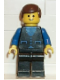

In [ ]:
path = 'minifigures'
img_file = '7595_preprocessed.jpg'
img = Image.open(os.path.join(path, img_file))
width, height = img.size